In [1]:
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import elementwise_grad

In [2]:
from autograd import grad

# autograd example

In [3]:
?elementwise_grad

Signature: elementwise_grad(fun, argnum=0, *nary_op_args, **nary_op_kwargs)
Docstring:
Returns a function that computes the sum of each column of the Jacobian of
`fun`, in one pass. If the Jacobian is diagonal, then this is the diagonal
of the Jacobian.
File:      ~/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/autograd/wrap_util.py
Type:      function


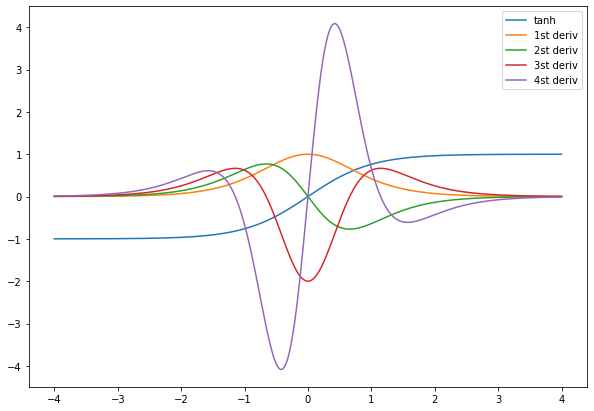

In [4]:
fig, ax = plt.subplots(figsize=(10,7))

x = np.linspace(-4, 4, 1000)

my_func = np.tanh

ax.plot(x, my_func(x), label='tanh')
for i in range(4):
    my_func = elementwise_grad(my_func)
    ax.plot(x, my_func(x), label=f'{i+1}st deriv')
plt.legend()

# leapfrom integrator 

In [5]:
def leapfrog(q, p, dVdq, path_len, step_size):
    """Leapfrog integrator for HMC
    
    my code differs from that off Colin Carrolls.
    see leap_frog_cc for his code.
    
    Parameters
    ----------
    q : np.floatX
        Initial position
    q : np.floatX
        Initial momentum
    dVdq : callable
        Gradient of the potential
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be
        
    Returns
    -------
    q, p : np.floatX, np.floatX
        New postiton and momentum
    """
    q, p = np.copy(q), np.copy(p)
    
    max_steps = int(np.floor(path_len/step_size))
    for n in range(0, max_steps):
        
        p_half_step = p - 0.5*step_size*dVdq(q)
        q_step = q + step_size*p_half_step
        
        p_step = p_half_step - 0.5*step_size*dVdq(q_step)
        p=p_step
        q=q_step
        
    return q_step, p_step

In [6]:
def leapfrog_cc(q, p, dVdq, path_len, step_size):
    """Leapfrog integrator for Hamiltonian Monte Carlo.

    Parameters
    ----------
    q : np.floatX
        Initial position
    p : np.floatX
        Initial momentum
    dVdq : callable
        Gradient of the velocity
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be

    Returns
    -------
    q, p : np.floatX, np.floatX
        New position and momentum
    """
    q, p = np.copy(q), np.copy(p)

    p -= step_size * dVdq(q) / 2  # half step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        p -= step_size * dVdq(q)  # whole step
    q += step_size * p  # whole step
    p -= step_size * dVdq(q) / 2  # half step

    # momentum flip at end
    return q, -p


# distributions

In [7]:
# https://github.com/ColCarroll/minimc/blob/master/minimc/autograd_interface/distributions.py

def neg_log_normal(mu, sigma):
    """
    logp(x | mu, sigma)
    """
    
    def logp(x):
        return 0.5 * (np.log(2*np.pi*sigma*sigma) + ((x-mu)/sigma)**2)
    return logp

In [8]:
neg_log_normal(0,1)

<function __main__.neg_log_normal.<locals>.logp(x)>

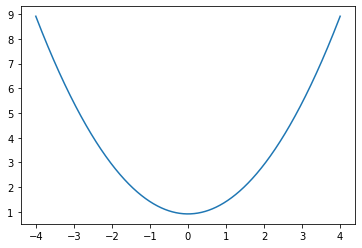

In [9]:
plt.figure()
plt.plot(x, neg_log_normal(0,1)(x))

# HMC function

In [13]:
import scipy.stats as st

In [14]:
st.norm(0, 1).rvs(size=1)

array([-0.14123017])

In [12]:
def hamiltonian_monte_carlo(n_samples, negative_log_prob, initial_position, path_len=1, step_size=0.5):
    """Run hamiltonian monte carlo sampling
    
    Parameters
    ----------
    n_samples : int
        Number of samples to return
    negative_log_prob : callable
        The negative log probability to sample from
    initial_position : np.array
        A place to start sampling from
    path_len : float
        How long each integration path is. Smaller is faster and more correlated (typically)
    step_size : float
        How long each integration step is. Smaller is slower and more accurate.
        
    Returns
    -------
    np.array
        Array of length `n_samples`
    """
    
    # autograd magic
    dVdq = grad(negative_log_prob)
    
    # collect all out samples in a list
    samples = [initial_position]
    
    # setup N(0,1) distribution to sample momentum from
    momentum = st.norm(0, 1)
    
    for n in range(n_samples):
        p0 = momentum.rvs(size=1)
        q_new, p_new = leapfrog(samples[-1], p0, dVdq, path_len, step_size)
#         q_new, p_new = leapfrog_cc(samples[-1], p0, dVdq, path_len, step_size)
#         p_new = -p_new
        
        # Metropolis acceptance criterion
        start_ham = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        end_ham = negative_log_prob(q_new) - np.sum(momentum.logpdf(-p_new))
        # note the minus sign infront of p_new! see 1701.02434 page 39
        ham_diff = start_ham - end_ham
        if np.log(np.random.rand()) < ham_diff:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))
            
            
    return np.array(samples[1:])

In [30]:
hmc_params = dict(
    n_samples=1000,
    negative_log_prob=neg_log_normal(0, 1),
    initial_position=np.array([1.]),
    path_len=10,
    step_size=0.5
)

In [31]:
samples = hamiltonian_monte_carlo(**hmc_params)

In [32]:
samples;

In [33]:
target_norm = st.norm(0, 1)

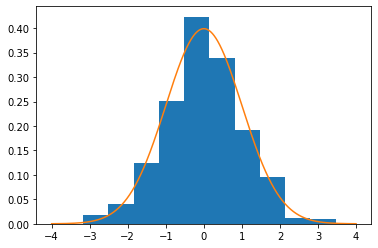

In [34]:
plt.figure()
plt.hist(samples, density=True);
plt.plot(x, target_norm.pdf(x))

In [35]:
import arviz as az

In [36]:
new_samples = samples.reshape(1, -1)

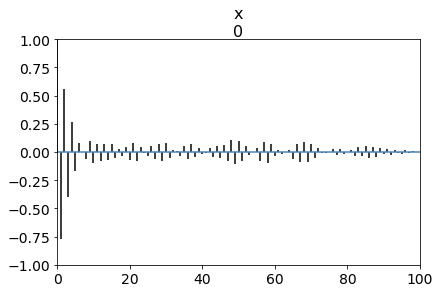

In [37]:
az.plot_autocorr(new_samples, var_names=["x"]);

In [38]:
%%time
path_lens = [1, 10, 100]
path_len_samples = []
for path_len in path_lens:
    hmc_params = dict(
        n_samples=1000,
        negative_log_prob=neg_log_normal(3, 1),
        initial_position=np.array([1.]),
        path_len=path_len,
        step_size=0.5
    )
    samples = hamiltonian_monte_carlo(**hmc_params)
    
    path_len_samples.append(samples.reshape(1, -1))

CPU times: user 1min 14s, sys: 131 ms, total: 1min 14s
Wall time: 1min 14s


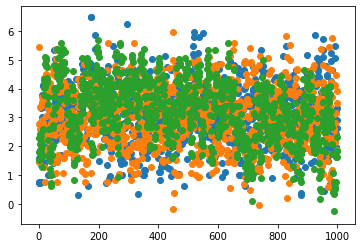

In [43]:
plt.figure()
plt.scatter(range(1000), path_len_samples[0])
plt.scatter(range(1000), path_len_samples[1])
plt.scatter(range(1000), path_len_samples[2])

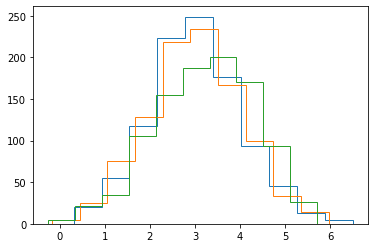

In [58]:
plt.figure()
plt.hist(path_len_samples[0][0], histtype='step');
plt.hist(path_len_samples[1][0], histtype='step');
plt.hist(path_len_samples[2][0], histtype='step');

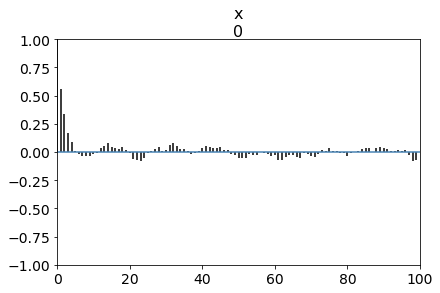

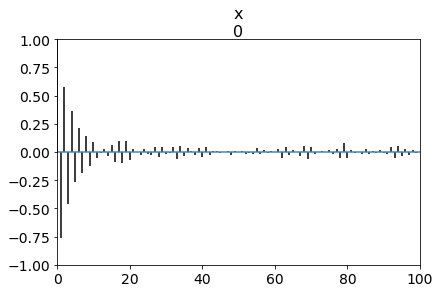

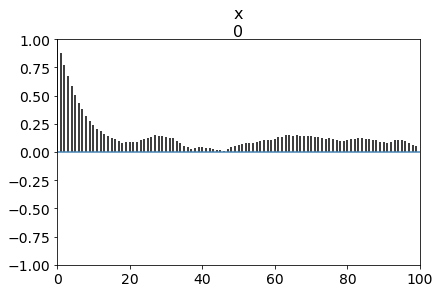

In [40]:
for path_len_sample in path_len_samples:
    az.plot_autocorr(path_len_sample, var_names=["x"]);

# plot position and momentum

In [15]:
def hmc_plot_leapfrog(q, p, dVdq, path_len, step_size):
    """
    ** hmc_plot_leapfrog **
    This is a modified implementation that returns the trajectories for fun.
    
    Leapfrog integrator for HMC
    
    my code differs from that off Colin Carrolls.
    see leap_frog_cc for his code.
    
    Parameters
    ----------
    q : np.floatX
        Initial position
    q : np.floatX
        Initial momentum
    dVdq : callable
        Gradient of the potential
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be
        
    Returns
    -------
    q, p : np.floatX, np.floatX
        New postiton and momentum
    qs, ps : np.array
        pos and mom trajectory
    """
    q, p = np.copy(q), np.copy(p)
    dtype=q.dtype
    
    max_steps = int(np.floor(path_len/step_size))
    dim = q.shape[0]
    
    shape = (max_steps, dim)
    
    qs = np.zeros(shape, dtype=dtype)
    ps = np.zeros(shape, dtype=dtype)
    
    for n in range(0, max_steps):
        p_half_step = p - 0.5*step_size*dVdq(q)
        q_step = q + step_size*p_half_step
        p_step = p_half_step - 0.5*step_size*dVdq(q_step)
        
        p=p_step
        q=q_step
        qs[n] = q_step
        ps[n] = p_step
        
    return q_step, p_step, qs, ps

In [57]:
def hmc_plot_hamiltonian_monte_carlo(n_samples, negative_log_prob, initial_position, path_len=1, step_size=0.5):
    """
    ** hmc_plot_hamiltonian_monte_carlo **
    This is a modified implementation that returns the trajectories for fun.
    
    Run hamiltonian monte carlo sampling
    
    Parameters
    ----------
    n_samples : int
        Number of samples to return
    negative_log_prob : callable
        The negative log probability to sample from
    initial_position : np.array
        A place to start sampling from
    path_len : float
        How long each integration path is. Smaller is faster and more correlated (typically)
    step_size : float
        How long each integration step is. Smaller is slower and more accurate.
        
    Returns
    -------
    np.array
        Array of length `n_samples`
    """
    
    # 
    dim = initial_position.shape[0]
    
    # setup arrays to keep all trajectories
    max_steps = int(np.floor(path_len/step_size))
    all_qs = np.zeros(shape=(n_samples, max_steps, dim))
    all_ps = np.zeros(shape=(n_samples, max_steps, dim))
    
    all_moms = np.zeros(shape=(n_samples, dim))
    
    # autograd magic
    dVdq = grad(negative_log_prob)
    
    # collect all out samples in a list
    samples = [initial_position]
    
    # setup N(0,1) distribution to sample momentum from
    momentum = st.norm(0, 1)
    
    # to work in more than 1D we need to specify the momentum shape
    # each dimension has it's own momentum draw.
    m_shape = dim
    
    for n in range(n_samples):
        p0 = momentum.rvs(size=m_shape)
        all_moms[n]=p0
        q_new, p_new, qs, ps = hmc_plot_leapfrog(samples[-1], p0, dVdq, path_len, step_size)
        
        all_qs[n] = qs
        all_ps[n] = ps
        
        # Metropolis acceptance criterion
        start_ham = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        end_ham = negative_log_prob(q_new) - np.sum(momentum.logpdf(-p_new))
        # note the minus sign infront of p_new! see 1701.02434 page 39
        ham_diff = start_ham - end_ham
        if np.log(np.random.rand()) < ham_diff:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))
            
            
    return np.array(samples[1:]), all_qs, all_ps, all_moms

In [58]:
hmc_params = dict(
    n_samples=1000,
    negative_log_prob=neg_log_normal(0, 1),
    initial_position=np.array([1.]),
    path_len=10,
    step_size=0.5
)

In [59]:
traj_x = np.arange(int(np.floor(hmc_params['path_len']/hmc_params['step_size'])))
xx = np.arange(hmc_params['n_samples'])

In [60]:
samples, qs, ps, moms = hmc_plot_hamiltonian_monte_carlo(**hmc_params)

In [61]:
samples;

In [62]:
samples.shape

(1000, 1)

In [63]:
qs[0]

array([[ 0.93694045],
       [ 0.63964579],
       [ 0.18243968],
       [-0.32037635],
       [-0.74309829],
       [-0.98004566],
       [-0.97198162],
       [-0.72092217],
       [-0.28963218],
       [ 0.21406586],
       [ 0.66424743],
       [ 0.94836714],
       [ 0.99539507],
       [ 0.79357423],
       [ 0.39335983],
       [-0.10519452],
       [-0.57745025],
       [-0.90534341],
       [-1.00690072],
       [-0.85673285]])

In [64]:
moms[0]

array([0.12388091])

In [65]:
momentum = st.norm(0, 1)

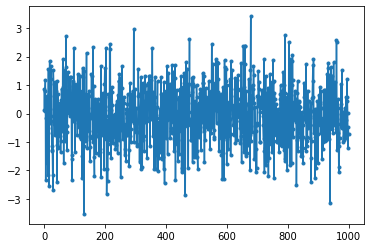

In [66]:
plt.figure()
# plt.plot(xx, momentum.logpdf(moms), '.-')
plt.plot(xx, moms, '.-')

In [67]:
qs[-1,-1]

array([0.67158008])

In [68]:
samples[-1]

array([0.67158008])

In [69]:
# the samples should be the last point in qs for each trajectory
for s, q in zip(samples, qs):
    print(s, q[-1])
    assert s == q[-1]

[-0.85673285] [-0.85673285]
[0.09563515] [0.09563515]
[-0.14168135] [-0.14168135]
[-0.40735425] [-0.40735425]
[-0.45031467] [-0.45031467]
[1.86639186] [1.86639186]
[-1.33863327] [-1.33863327]
[0.72812248] [0.72812248]
[-0.95588154] [-0.95588154]
[0.97909884] [0.97909884]
[0.36710586] [0.36710586]
[0.16244859] [0.16244859]
[1.291706] [1.291706]
[-0.67320676] [-0.67320676]
[-0.50014419] [-0.50014419]
[2.04543823] [2.04543823]
[-2.0333643] [-2.0333643]
[1.43815396] [1.43815396]
[1.43815396] [-2.31864794]


AssertionError: 

Text(0, 0.5, 'p')

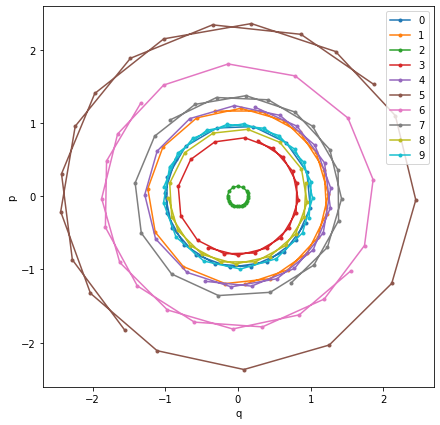

In [70]:
plt.figure(figsize=(7,7))
for i in range(10):
    plt.plot(qs[i], ps[i], '.-', label=f'{i}')
plt.legend()
plt.xlabel('q')
plt.ylabel('p')

Text(0, 0.5, 'xx')

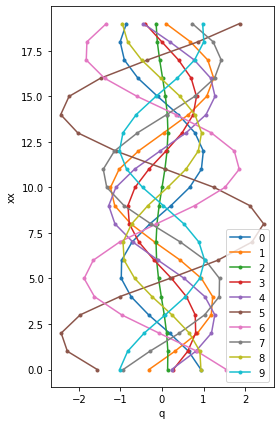

In [71]:
plt.figure(figsize=(4,7))
for i in range(10):
    plt.plot(qs[i], traj_x, '.-', label=f'{i}')
plt.legend()

plt.xlabel('q')
plt.ylabel('xx')

Text(0, 0.5, 'q')

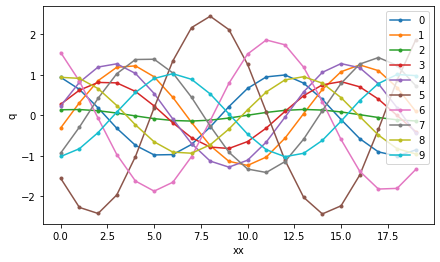

In [72]:
plt.figure(figsize=(7,4))
for i in range(10):
    plt.plot(traj_x, qs[i], '.-', label=f'{i}')
plt.legend()
plt.xlabel('xx')
plt.ylabel('q')

Text(0, 0.5, 'p')

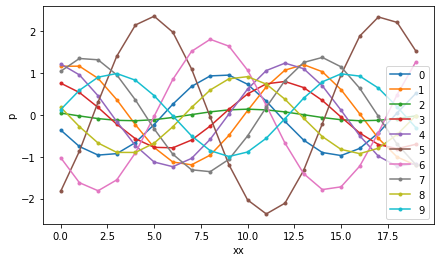

In [73]:
plt.figure(figsize=(7,4))
for i in range(10):
    plt.plot(traj_x, ps[i], '.-', label=f'{i}')
plt.legend()
plt.xlabel('xx')
plt.ylabel('p')

In [74]:
target_norm = st.norm(0, 1)

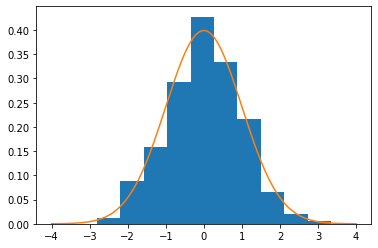

In [75]:
plt.figure()
plt.hist(samples, density=True);
plt.plot(x, target_norm.pdf(x))

# trying multidimensional

In [35]:
# https://github.com/ColCarroll/minimc/blob/master/minimc/autograd_interface/distributions.py
from autograd.scipy.special import logsumexp


def neg_log_mvnormal(mu, sigma):
    """Use a Cholesky decomposition for more careful work."""

    def logp(x):
        k = mu.shape[0]
        return (
            k * np.log(2 * np.pi)
            + np.log(np.linalg.det(sigma))
            + np.dot(np.dot((x - mu).T, np.linalg.inv(sigma)), x - mu)
        ) * 0.5

    return logp


def neg_log_funnel():
    """Neal's funnel.
    The pdf is
    p(x) = N(x[0] | 0, 1) N(x[1:] | 0, exp(2 * x[0]) I )
    May cause divergences!
    """
    scale = neg_log_normal(0, 1)

    def neg_log_p(x):
        funnel_dim = x.shape[0] - 1
        if funnel_dim == 1:
            funnel = neg_log_normal(0, np.exp(2 * x[0]))
        else:
            funnel = neg_log_mvnormal(
                np.zeros(funnel_dim), np.exp(2 * x[0]) * np.eye(funnel_dim)
            )
        return scale(x[0]) + funnel(x[1:])

    return neg_log_p


def mixture(neg_log_probs, probs):
    """Log probability of a mixture of probabilities.
    neg_log_probs should be an iterator of negative log probabilities
    probs should be an iterator of floats of the same length that sums to 1-ish
    """
    probs = np.array(probs) / np.sum(probs)
    assert len(neg_log_probs) == probs.shape[0]

    def logp(x):
        return -logsumexp(np.log(probs) - np.array([logp(x) for logp in neg_log_probs]))

    return logp

In [36]:
np.random.seed(7)

mu1 = np.ones(2)
cov1 = 0.5 * np.array([[1., 0.7],
                       [0.7, 1.]])
mu2 = -mu1
cov2 = 0.2 * np.array([[1., -0.6],
                       [-0.6, 1.]])

mu3 = np.array([-1., 2.])
cov3 = 0.3 * np.eye(2)

neg_log_p = mixture([neg_log_mvnormal(mu1, cov1), neg_log_mvnormal(mu2, cov2), neg_log_mvnormal(mu3, cov3)], [0.3, 0.3, 0.4])
dVdq = grad(neg_log_p)

In [37]:
positions, momentums = [], []
for _ in range(3):
    q, p = np.random.randn(2, 2)
    _, _, q, p = hmc_plot_leapfrog(q, p, dVdq, 4 * np.pi, 0.01)
    positions.append(q)
    momentums.append(p)

In [38]:
positions[0]

array([[ 1.6905173 , -0.46147999],
       [ 1.68983692, -0.45625993],
       [ 1.68848625, -0.45027942],
       ...,
       [-1.45857284, -1.64014749],
       [-1.45044905, -1.60906782],
       [-1.4416909 , -1.5773038 ]])

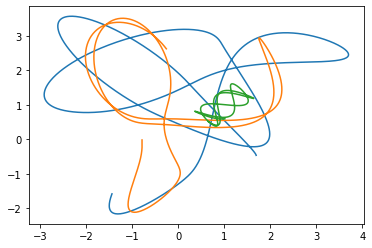

In [39]:
plt.figure()
plt.plot(positions[0][:,0], positions[0][:,1])

plt.plot(positions[1][:,0], positions[1][:,1])

plt.plot(positions[2][:,0], positions[2][:,1])

In [40]:
def neg_log_p_to_img(neg_log_p, extent=None, num=100):
    if extent is None:
        extent = (-3, 3, -3, 3)
    X, Y = np.meshgrid(np.linspace(*extent[:2], num), np.linspace(*extent[2:], num))
    Z = np.array([np.exp(-neg_log_p(j)) for j in np.array((X.ravel(), Y.ravel())).T]).reshape(X.shape)
    return Z, extent

In [41]:
Z, extent = neg_log_p_to_img(neg_log_p, (-3, 4, -3, 4), num=200)

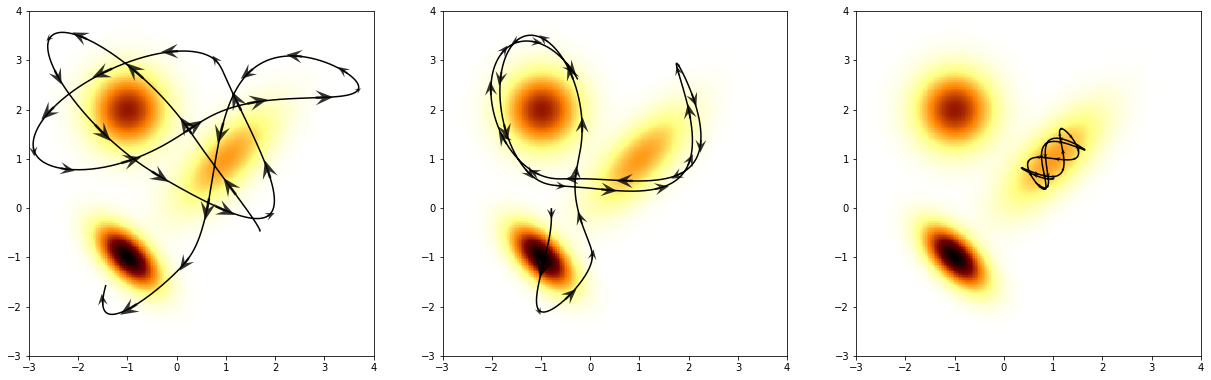

In [42]:
fig, axes = plt.subplots(ncols=len(positions), figsize=(7*len(positions),7))
steps = slice(None, None, 40)
for idx, (ax, q, p) in enumerate(zip(axes.ravel(), positions, momentums)):
    ax.imshow(Z, origin='top', extent=extent, cmap='afmhot_r')
    ax.quiver(q[steps, 0], q[steps, 1], p[steps, 0], p[steps, 1],headwidth=6, scale=60, headlength=7, alpha=0.8, color='k')
    ax.plot(q[:,0], q[:,1], c='k')
    

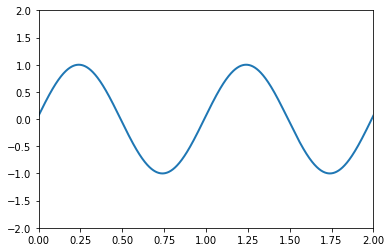

In [45]:
# http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

HTML(anim.to_html5_video())

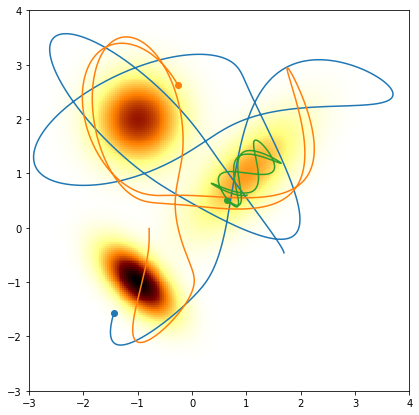

In [46]:
# http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(7,7))

ax.set_xlim((-3, 4))
ax.set_ylim((-3, 4))

ax.imshow(Z, origin='top', extent=extent, cmap='afmhot_r')

l1, = ax.plot([], [], 'o', color='C0')
l2, = ax.plot([], [], 'o', color='C1')
l3, = ax.plot([], [], 'o', color='C2')

ax.plot(positions[0][:,0], positions[0][:,1])
ax.plot(positions[1][:,0], positions[1][:,1])
ax.plot(positions[2][:,0], positions[2][:,1])

# initialization function: plot the background of each frame
# def init():
#     line.set_data([], [])
#     return (line,)

# animation function. This is called sequentially
def animate(i):
    x = positions[0][i,0]
    y = positions[0][i,1]
    l1.set_data(x, y)
    
    x = positions[1][i,0]
    y = positions[1][i,1]
    l2.set_data(x, y)
    
    x = positions[2][i,0]
    y = positions[2][i,1]
    l3.set_data(x, y)
    return (l1,l2,l3)

# call the animator. blit=True means only re-draw the parts that have changed.
# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=100, interval=20, blit=True)

tot_frames = positions[0].shape[0]
len_anim = 10

anim = animation.FuncAnimation(fig, animate,
                               frames=tot_frames, interval=len_anim, blit=True);

HTML(anim.to_html5_video())

In [75]:
# %%time
# anim.save('hmc.mp4')

CPU times: user 55.3 s, sys: 981 ms, total: 56.3 s
Wall time: 56.9 s


In [148]:
hmc_params = dict(
    n_samples=1000,
    negative_log_prob=neg_log_p,
    initial_position=np.array([10., 10.,]),
    path_len=10,
    step_size=0.5
)

In [149]:
traj_x = np.arange(int(np.floor(hmc_params['path_len']/hmc_params['step_size'])))
xx = np.arange(hmc_params['n_samples'])

In [150]:
%%time
samples, qs, ps, moms = hmc_plot_hamiltonian_monte_carlo(**hmc_params)

CPU times: user 45.4 s, sys: 339 ms, total: 45.7 s
Wall time: 46 s


In [151]:
samples.shape

(1000, 2)

In [152]:
qs[0]

array([[ 8.81197044,  8.15410212],
       [ 4.87482426,  4.65553482],
       [-0.35246887,  0.23230297],
       [-4.81854975, -4.32108075],
       [-7.23189217, -7.65084101],
       [-7.51160375, -8.14872236],
       [-5.72514072, -5.51856476],
       [-1.81892731, -1.11295004],
       [ 3.81769952,  4.4694171 ],
       [ 9.07284836,  8.58411028],
       [11.61822155, 10.80359128],
       [10.48152842, 10.69872307],
       [ 6.7052056 ,  7.59223409],
       [ 1.85962618,  1.9381077 ],
       [-3.18493545, -4.0457907 ],
       [-7.58941673, -7.95484999],
       [-9.7183865 , -8.97934234],
       [-8.18770249, -7.57592117],
       [-3.53490312, -4.07002017],
       [ 2.0844541 ,  1.29430043]])

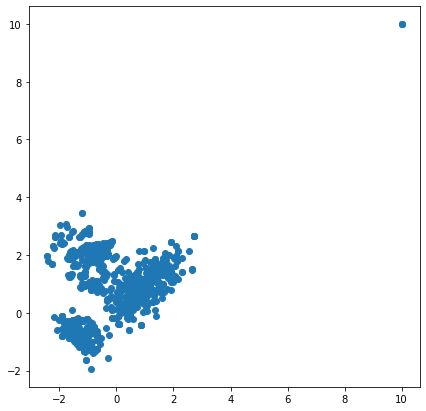

In [153]:
plt.figure(figsize=(7,7))
plt.scatter(samples[:,0], samples[:,1])
# plt.imshow(Z, origin='top', extent=extent, cmap='afmhot_r')

In [154]:
az_data = az.from_dict({"x":samples[:,0], "y":samples[:,1]})

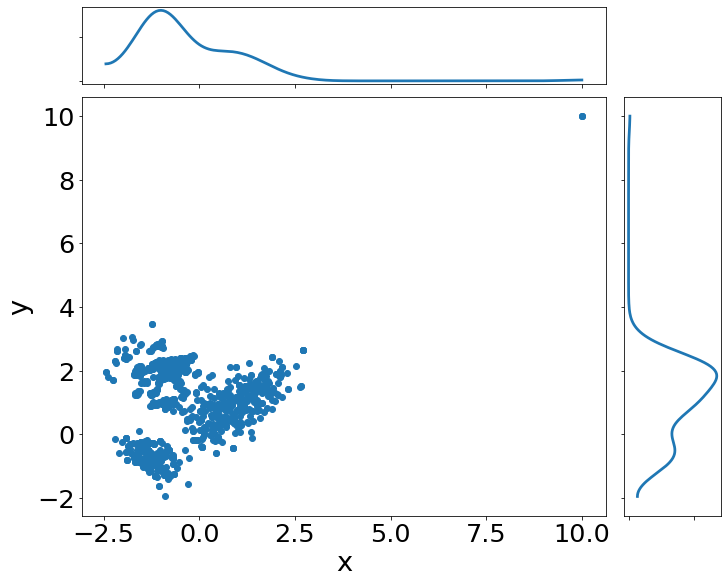

In [155]:
ax = az.plot_joint(
    az_data,
    var_names=["x", "y"],
    kind='scatter',
    figsize=(10, 8),
)

plt.show()

# try another distribution

In [156]:
np.random.seed(7)

mu1 = np.ones(2)
cov1 = 0.5 * np.array([[1., 0.7],
                       [0.7, 1.]])
mu2 = -mu1
cov2 = 0.2 * np.array([[1., -0.6],
                       [-0.6, 1.]])

mu3 = np.array([6., 6.])
cov3 = 0.3 * np.eye(2)

new_neg_log_p = mixture([neg_log_mvnormal(mu1, cov1), neg_log_mvnormal(mu2, cov2), neg_log_mvnormal(mu3, cov3)], [0.3, 0.3, 0.4])

In [177]:
new_Z, new_extent = neg_log_p_to_img(new_neg_log_p, (-10, 10, -10, 10), num=200)

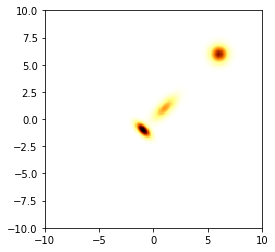

In [178]:
plt.figure()
plt.imshow(new_Z, origin='top', extent=new_extent, cmap='afmhot_r')

In [225]:
hmc_params = dict(
    n_samples=1000,
    negative_log_prob=new_neg_log_p,
    initial_position=np.array([10., 0.,]),
    path_len=2,
    step_size=0.5
)

In [226]:
traj_x = np.arange(int(np.floor(hmc_params['path_len']/hmc_params['step_size'])))
xx = np.arange(hmc_params['n_samples'])

In [227]:
%%time
samples, qs, ps, moms = hmc_plot_hamiltonian_monte_carlo(**hmc_params)

CPU times: user 9.2 s, sys: 52 ms, total: 9.25 s
Wall time: 9.3 s


In [228]:
samples.shape

(1000, 2)

In [229]:
qs[0]

array([[ 7.98088115,  2.62576245],
       [ 4.311028  ,  8.06338952],
       [ 2.04865152, 11.78152533],
       [ 3.07906544, 10.68172336]])

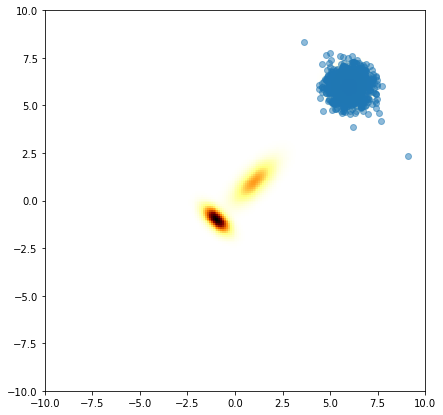

In [230]:
plt.figure(figsize=(7,7))
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, marker='o')
plt.imshow(new_Z, origin='top', extent=new_extent, cmap='afmhot_r')

In [223]:
az_data = az.from_dict({"x":samples[:,0], "y":samples[:,1]})

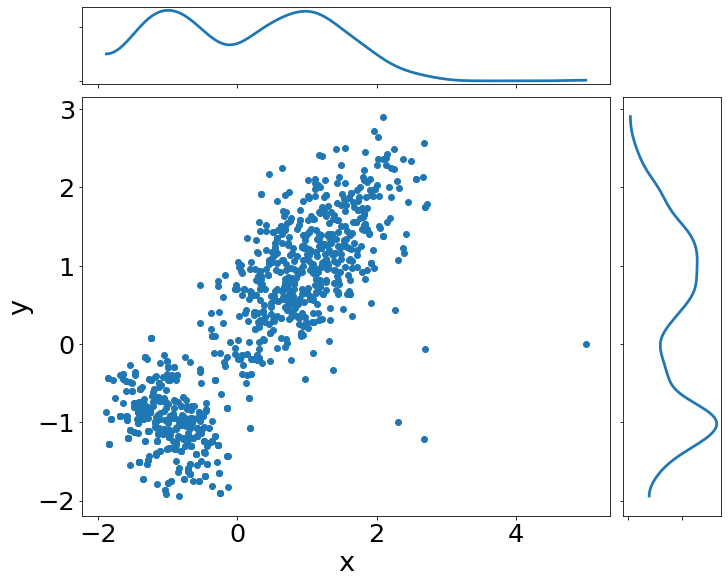

In [224]:
ax = az.plot_joint(
    az_data,
    var_names=["x", "y"],
    kind='scatter',
    figsize=(10, 8),
)

plt.show()